In [240]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

def explode_calibrations(df):
    a = df["calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["calibrations"])
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["calibrations","ps"])
    # rename the exploded columns
    df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
    return df
df_state_evolution = explode_calibrations(df_state_evolution)
def explode_erm_calibrations(df):
    a = df["erm_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["erm_calibrations"])
    b = df["analytical_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["analytical_calibrations"])
    # drop the dp and ps columns from b
    b = b.drop(columns=["dp","ps"])
    # rename the columns of b
    b = b.rename(columns={"calibrations":"analytical_calibration"})
    # rename the columns of a
    a = a.rename(columns={"calibrations":"erm_calibration"})
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    df = pd.concat([df,b],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["erm_calibration","analytical_calibration","ps"])
    # rename the exploded columns
    df = df.rename(columns={"ps":"p_calibration"})
    return df
df_erm = explode_erm_calibrations(df_erm)
print("Current code version, ", __version__)

Current code version,  71


In [242]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,test_against_largest_epsilon,lambdas,taus,ps,dp,d,experiment_type,completed,data_model_type,data_model_name,data_model_description
8,9a485afe-4ec5-4622-b294-2d4e4500b274,Source Capacity Sweep Robustness Test,718.348005,71,2023-11-06 15:57:32,1,2,"[0.5, 3.6667, 6.8333, 10.0]","[0.0, 0.6]",1,"[0.02, 10.0]",[0],"[0.6, 0.75, 0.9]",0.01,1000,Sweep,1,SourceCapacity,SourceCapacity_IDStudentPrior,Source Capacity data model with Identity Gauss...
7,e2f06424-c92e-49fb-b4f4-f1737d7f3a32,Source Capacity Sweep Robustness Test,505.648858,71,2023-11-06 15:34:53,1,2,"[0.5, 3.6667, 6.8333, 10.0]","[0.0, 0.6]",1,"[0.02, 10.0]",[0],"[0.6, 0.75, 0.9]",0.01,1000,Sweep,1,SourceCapacity,SourceCapacity_IDStudentPrior,Source Capacity data model with Identity Gauss...
6,bc2be070-53af-4a1d-97f7-6d543cc0d0ff,Vanilla Gaussian Alpha Sweep Robustness Tests,100.226344,71,2023-11-06 15:31:14,1,2,"[0.5, 3.6667, 6.8333, 10.0]","[0.0, 0.6]",1,"[0.05, 10.0]",[0],"[0.6, 0.75, 0.9]",0.01,1000,Sweep,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...


In [243]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [244]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[experiment_loc]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[experiment_loc]["data_model_name"]
data_model_description = df_experiments.iloc[experiment_loc]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

9a485afe-4ec5-4622-b294-2d4e4500b274
SourceCapacity SourceCapacity_IDStudentPrior
Source Capacity data model with Identity Gaussian Prior and a teacher with alpha = 1.2, r = 0.3
Source Capacity Sweep Robustness Test


In [245]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]

gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))


# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","p_calibration"]) 
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","p_calibration"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","cosb","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","calibration","test_loss", "student_robustness", "teacher_robustness","adversarial_generalization_error_overlaps","adversarial_generalization_error_overlaps_teacher"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap","A","N","erm_calibration","analytical_calibration", "student_robustness", "teacher_robustness","adversarial_generalization_error_overlaps","adversarial_generalization_error_erm_teacher"]] 
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution","test_loss_state_evolution", "student_robustness_erm", "teacher_robustness_erm", "student_robustness_state_evolution", "teacher_robustness_state_evolution","adversarial_generalization_error_overlaps_erm","adversarial_generalization_error_overlaps_state_evolution","adversarial_generalization_error_erm_teacher_erm","adversarial_generalization_error_overlaps_teacher_state_evolution"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std]) 
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_402/2864236402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_402/2864236402.py:30: FutureWarning: The provided callable <function mean at 0x10554c2c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_402/2864236402.py:30: FutureWarning: The provided callable <function std at 0x10554c4a0> is

generalization_error_state_evolution  \
                                                                      mean   
alpha epsilon tau lam   p_calibration                                        
0.4   0.0     0.0 0.02  0.60                                      0.076537   
                        0.75                                      0.076537   
                        0.90                                      0.076537   
                  10.00 0.60                                      0.116674   
                        0.75                                      0.116674   
                        0.90                                      0.116674   
      0.6     0.0 0.02  0.60                                      0.076662   
                        0.75                                      0.076662   
                        0.90                                      0.076662   
                  10.00 0.60                                      0.118058   
                        0.75                                      0.118058   
                        0.90                                      0.118058   
3.6   0.0     0.0 0.02  0.60                                      0.039956   
                        0.75                                      0.039956   
                        0.90                                      0.039956   
                  10.00 0.60                                      0.074695   
                        0.75                                      0.074695   
                        0.90                                      0.074695   
      0.6     0.0 0.02  0.60                                      0.040104   
                        0.75                                      0.040104   
                        0.90                                      0.040104   
                  10.00 0.60                                      0.077066   
                        0.75                                      0.077066   
                        0.90                                      0.077066   
6.8   0.0     0.0 0.02  0.60                                      0.030895   
                        0.75                                      0.030895   
                        0.90                                      0.030895   
                  10.00 0.60                                      0.064217   
                        0.75                                      0.064217   
                        0.90                                      0.064217   
      0.6     0.0 0.02  0.60                                      0.031036   
                        0.75                                      0.031036   
                        0.90                                      0.031036   
                  10.00 0.60                                      0.066974   
                        0.75                                      0.066974   
                        0.90                                      0.066974   
10.0  0.0     0.0 0.02  0.60                                      0.025709   
                        0.75                                      0.025709   
                        0.90                                      0.025709   
                  10.00 0.60                                      0.058369   
                        0.75                                      0.058369   
                        0.90                                      0.058369   
      0.6     0.0 0.02  0.60                                      0.026704   
                        0.75                                      0.026704   
                        0.90                                      0.026704   
                  10.00 0.60                                      0.061390   
                        0.75                                      0.061390   
                        0.90                                      0.061390   

                                           generalization_e

In [246]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [247]:
first_iteration = "tau"
second_iteration = "lam" # "lam"
target = "alpha"
sweep = "epsilon"
save_plots = False
description = ""
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]



    for tau in df2[first_iteration].unique():

        iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

        for lam in iterate_over:

            fig = plt.figure()
            ax = plt.subplot(111)

            # Filter the dataframe for the current values of tau and lam
            if second_iteration is None:
                data = df2[(df2[first_iteration] == tau)]
            else:
                data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                        ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                    else:
                        ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name)
                    # plot the optimal lambda as a vertical line
                    if optimal_lambda is not None:
                        ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
                # plt.xscale('symlog')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}',y=1.1)
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}',y=1.1)
            else:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d}',y=1.1)
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}',y=1.1)
            

            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

            # add a grid
            plt.grid()

            plt.tight_layout()

            if fix_a_variable is not None:
                name = f"{error_name}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            if filename is not None or save_plots:

                # make sure the directory for the data_model_name exists
                directory = f"Assets/{data_model_name}"
                if not os.path.exists(directory):
                    os.makedirs(directory)

                # encode the sweep type as a directory
                sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
                directory = f"Assets/{data_model_name}/{sweep_name}"
                if not os.path.exists(directory):
                    os.makedirs(directory)

                if save_plots and filename is None:
                    filename = description

                plt.savefig(f"Assets/{data_model_name}/{sweep_name}/{filename}_{name}.pdf", bbox_inches='tight')

            # Show the plot
            plt.show()

In [248]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [249]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

In [250]:
# create_plot(df,"Adversarial Generalization Error Teacher","adversarial_generalization_error_overlaps_teacher_state_evolution", "adversarial_generalization_error_erm_teacher_erm")

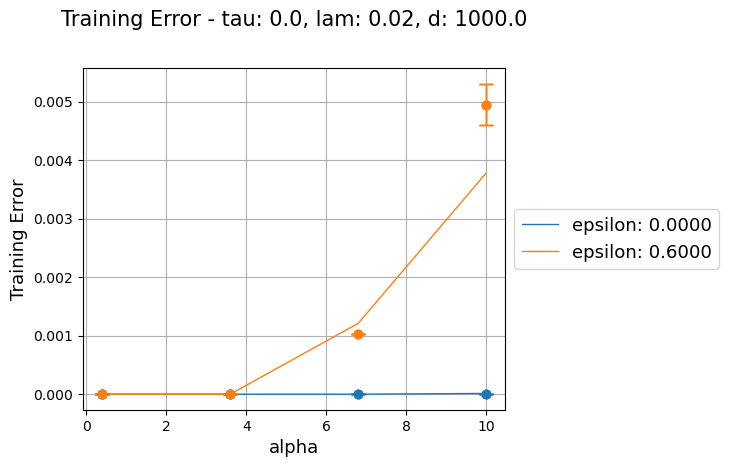

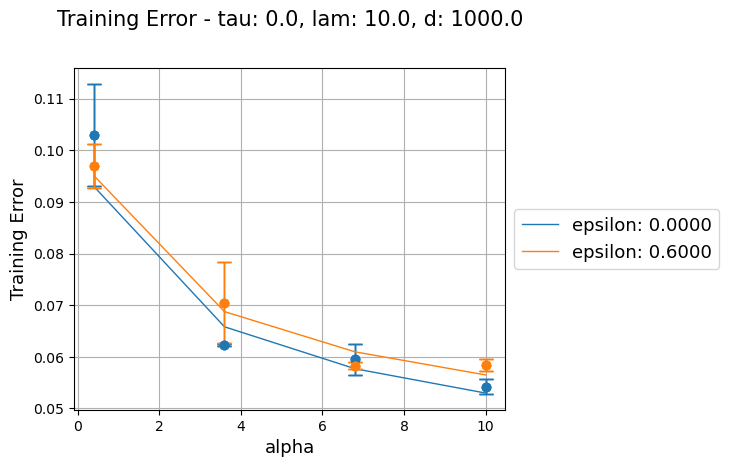

In [251]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False,log_x=False)

In [252]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

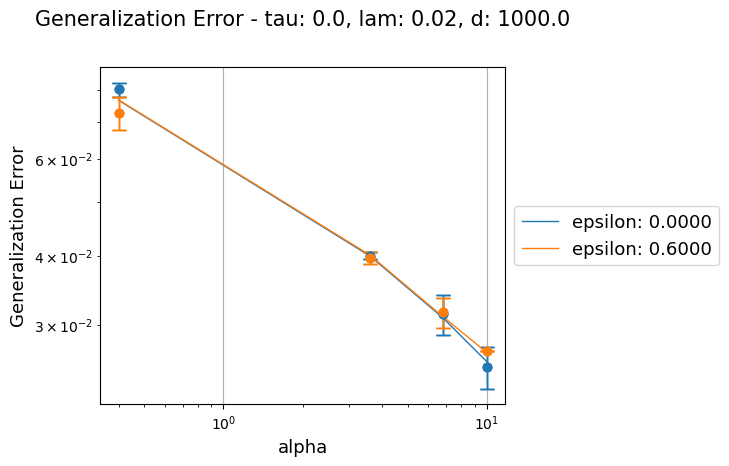

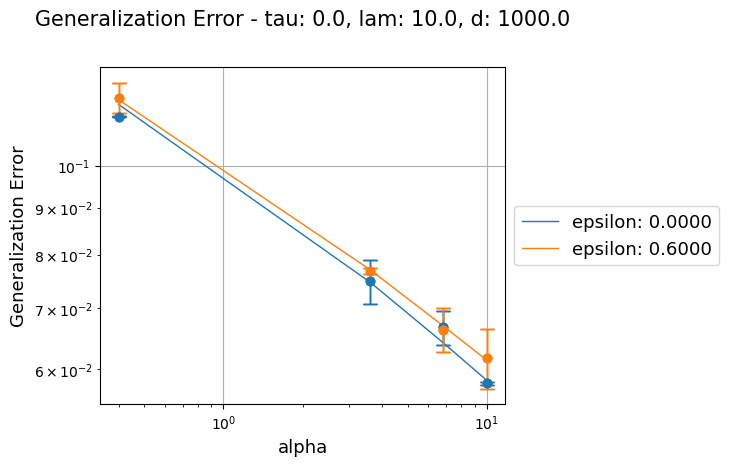

In [278]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

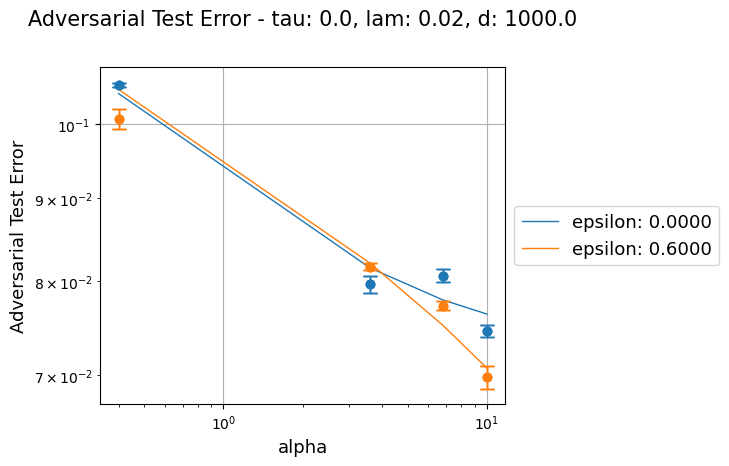

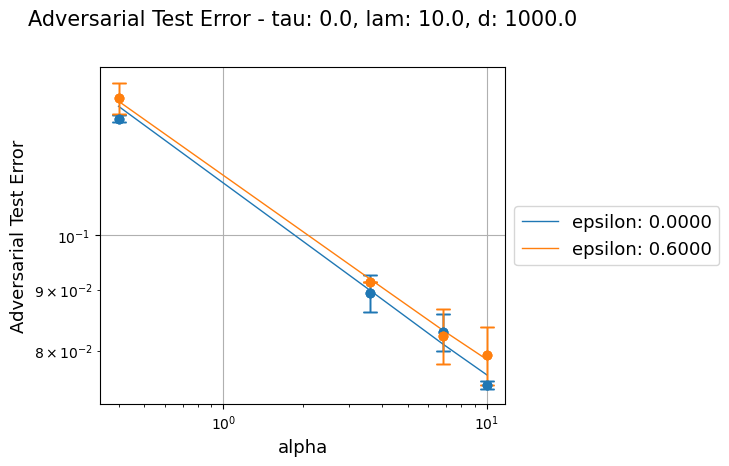

In [254]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_overlaps_state_evolution", "adversarial_generalization_error_erm_erm",log_y=True,log_x=True)

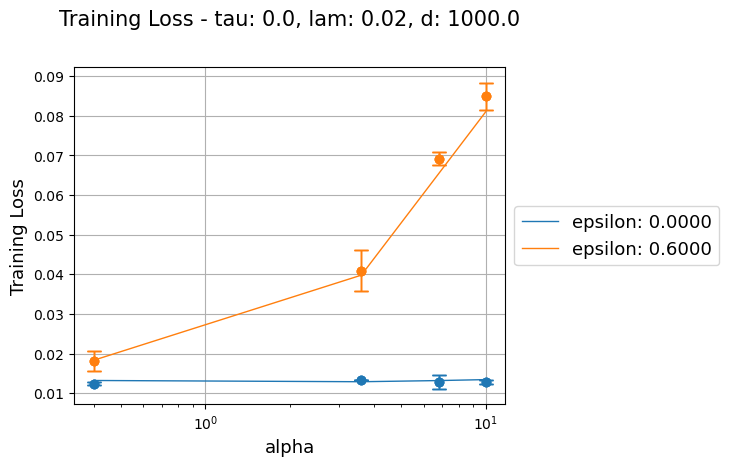

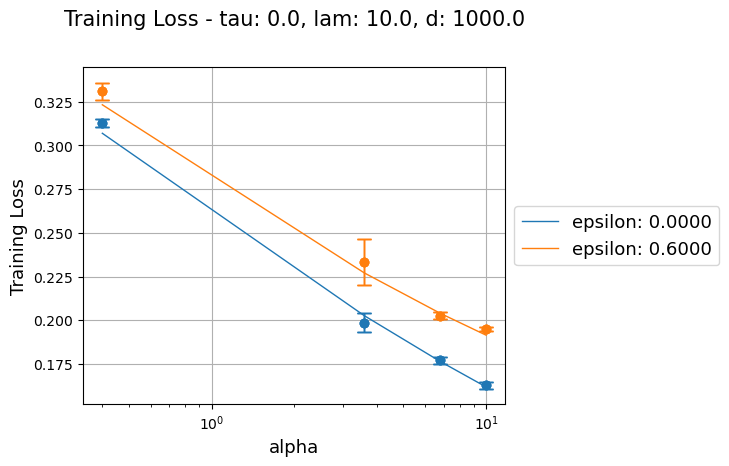

In [255]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=False)

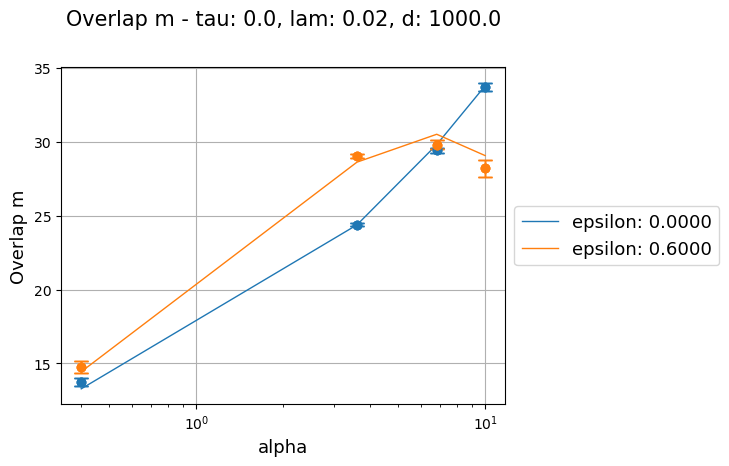

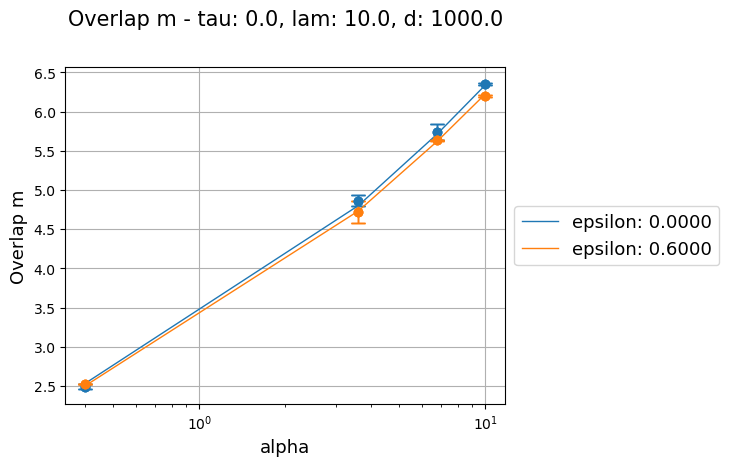

In [256]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=False)

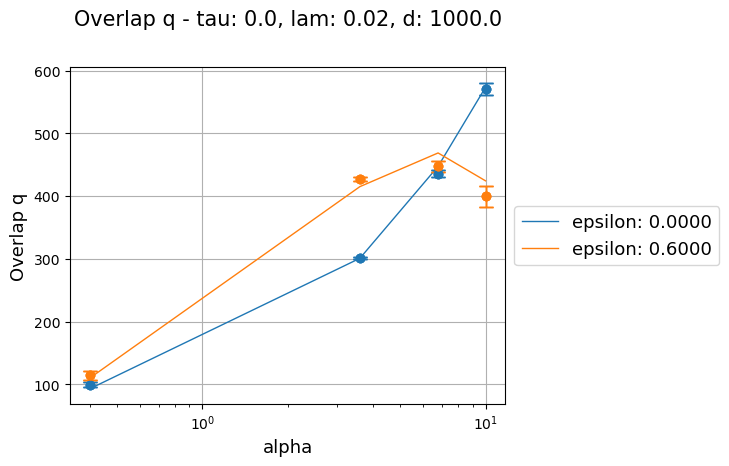

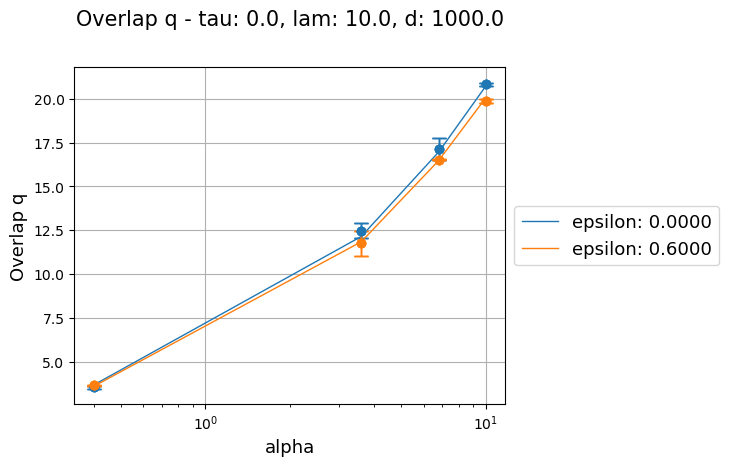

In [257]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=False)

In [258]:
# Plot the Q_self_state_evolution overlap vs Q_erm
# create_plot(df, "Overlap Q", "Q_self_state_evolution","Q_erm", log_y=False)

In [259]:
# Plot the A_self overlap
# create_plot(df, "A_self", "A_self_state_evolution","A_erm", log_y=False)

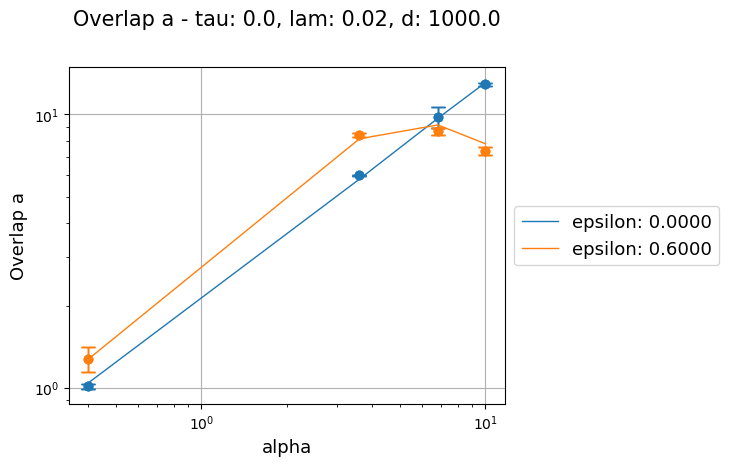

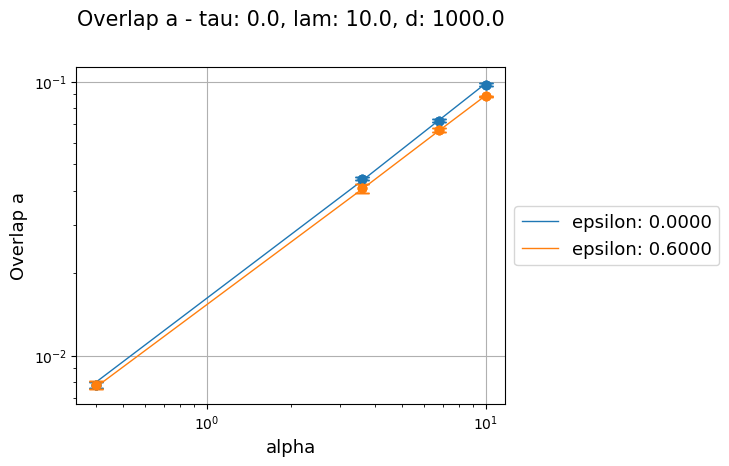

In [260]:
# Plot the a overlap
create_plot(df, "Overlap a", "A_state_evolution","A_erm", log_y=True)

In [261]:
# Plot the N_self overlap
# create_plot(df, "N_self", "N_self_state_evolution","N_erm", log_y=False)

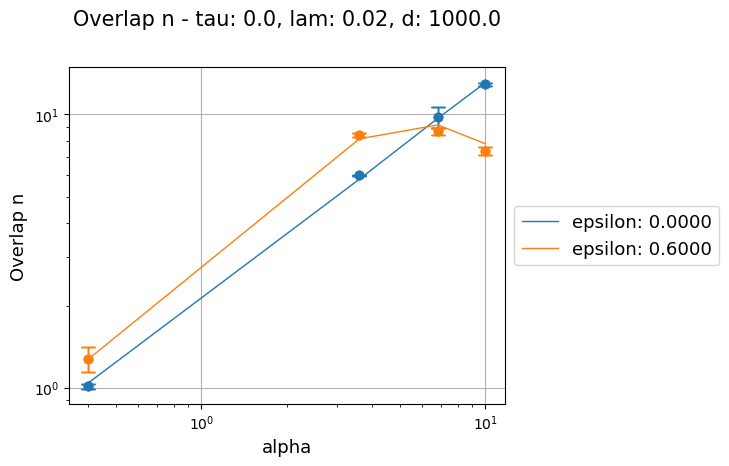

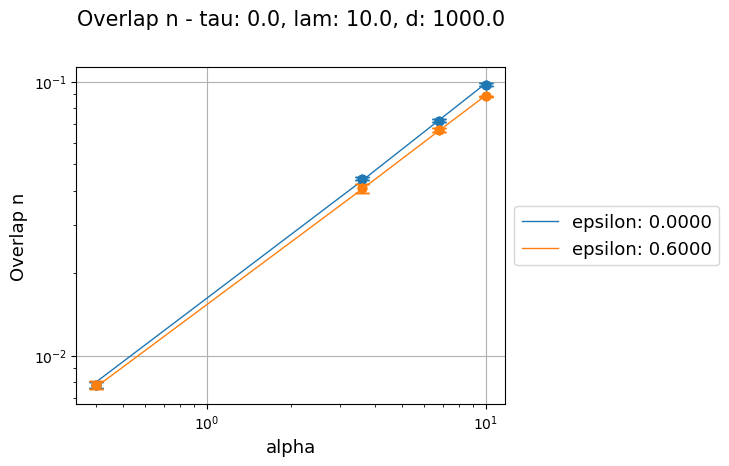

In [262]:
# Plot the n overlap
create_plot(df, "Overlap n", "N_state_evolution","N_erm", log_y=True)

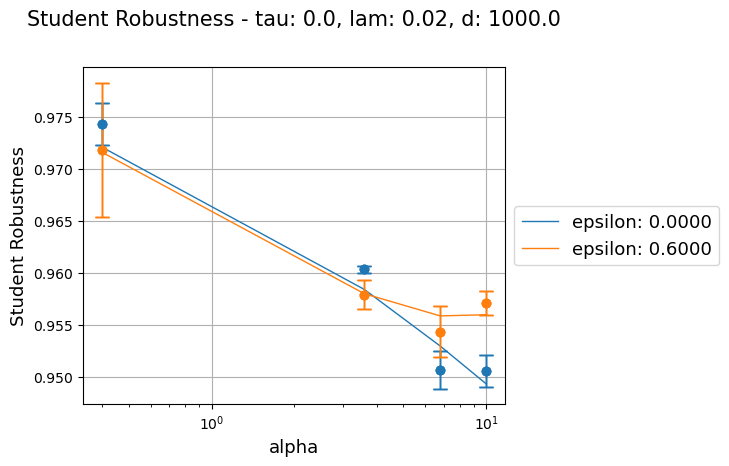

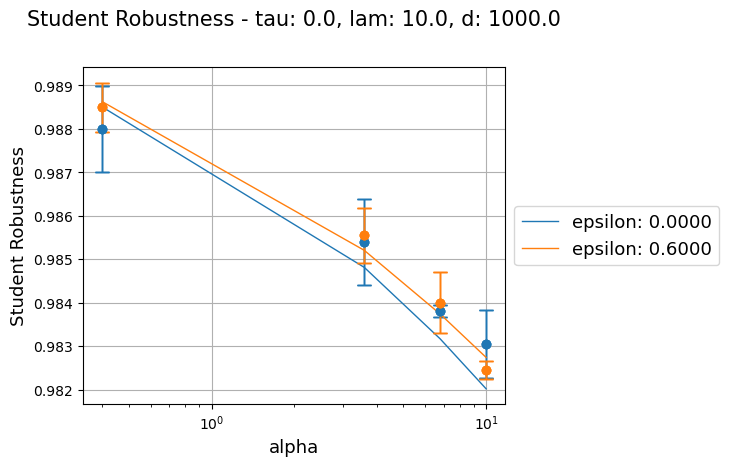

In [263]:
# Plot the student_robustness
create_plot(df, "Student Robustness", "student_robustness_state_evolution","student_robustness_erm", log_y=False)

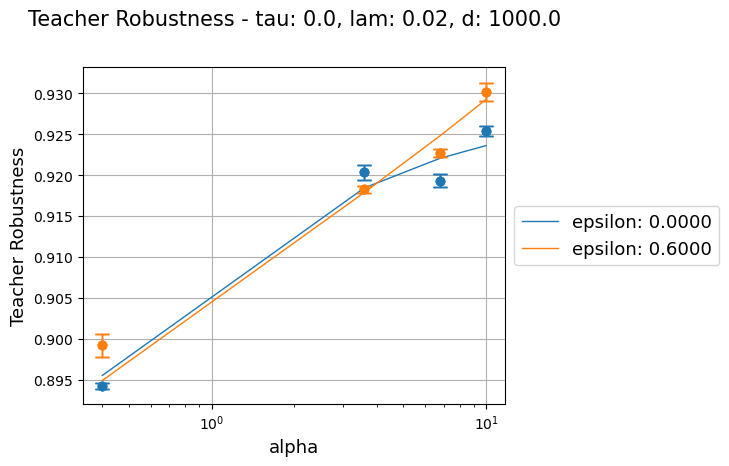

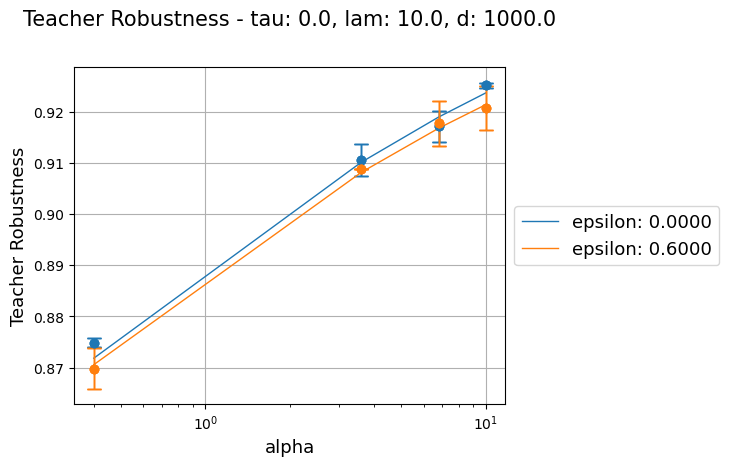

In [264]:
# Plot the teacher robustness
create_plot(df, "Teacher Robustness", "teacher_robustness_state_evolution","teacher_robustness_erm", log_y=False)

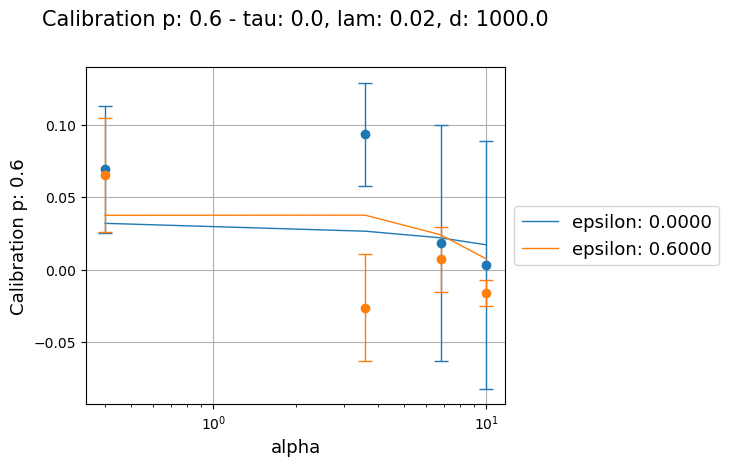

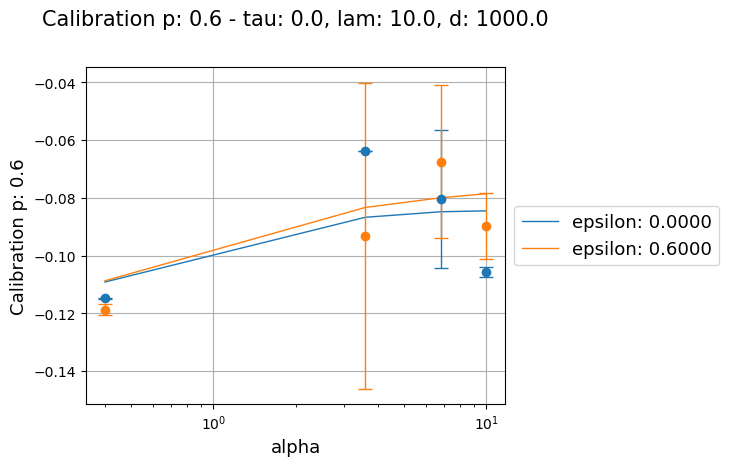

In [265]:
# subset df to keep only where p = 0.5
p = 0.6
dfp = df[df.index.get_level_values("p_calibration") == p]
# remove epsilon = 1
# dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

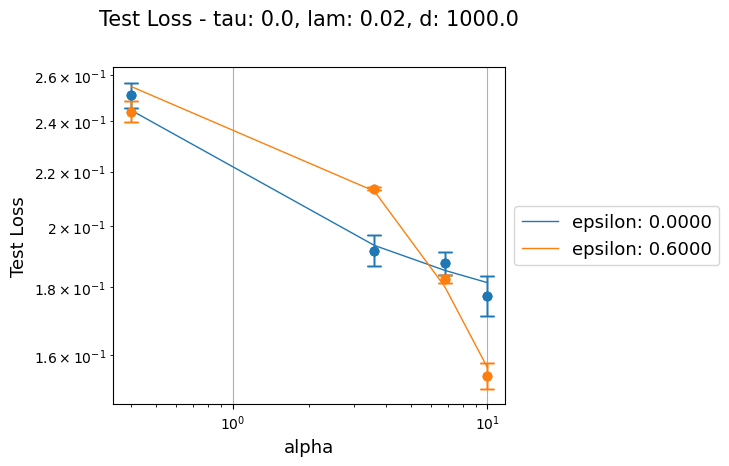

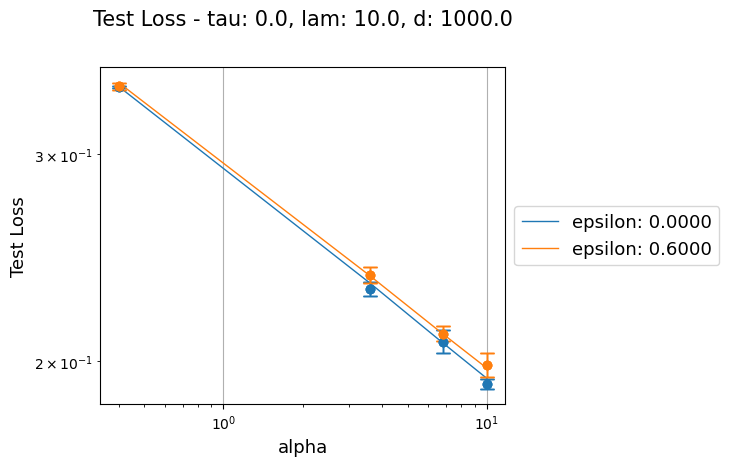

In [266]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True)

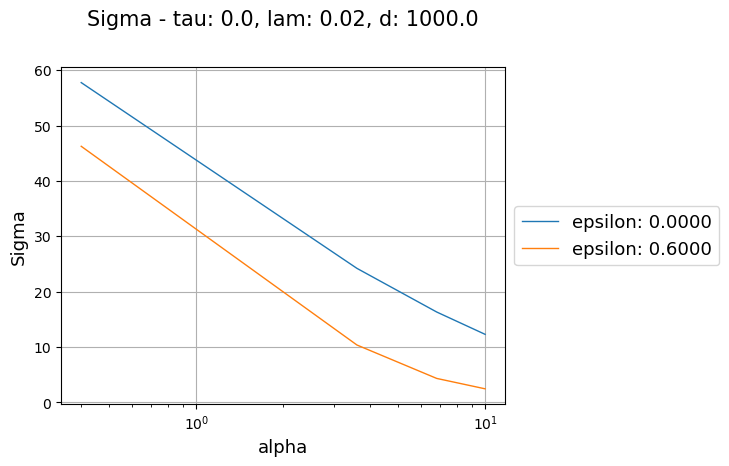

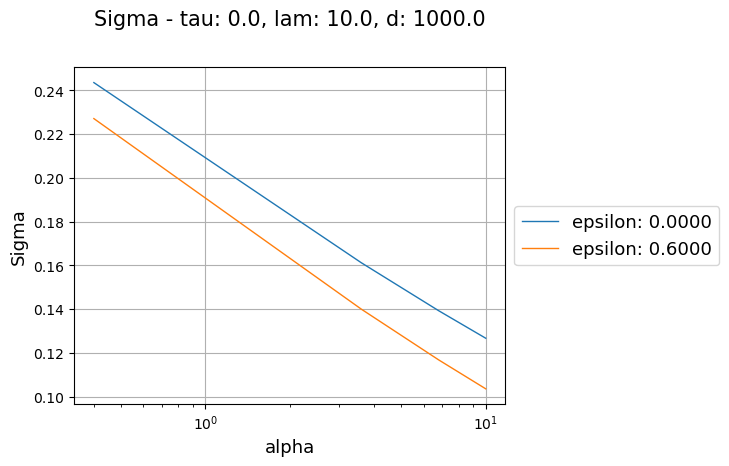

In [267]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

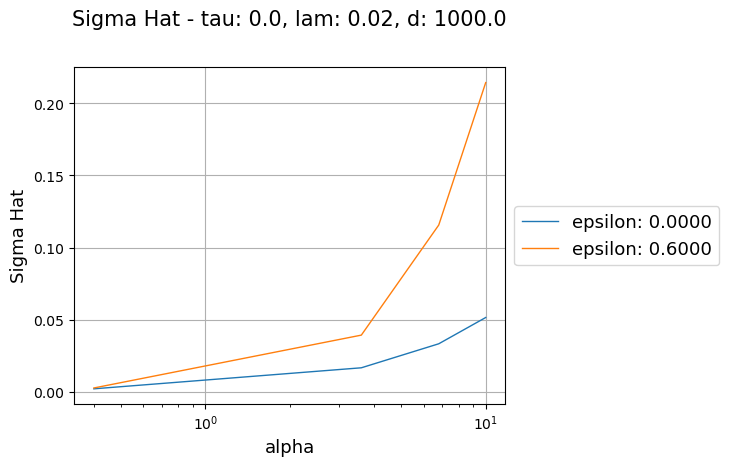

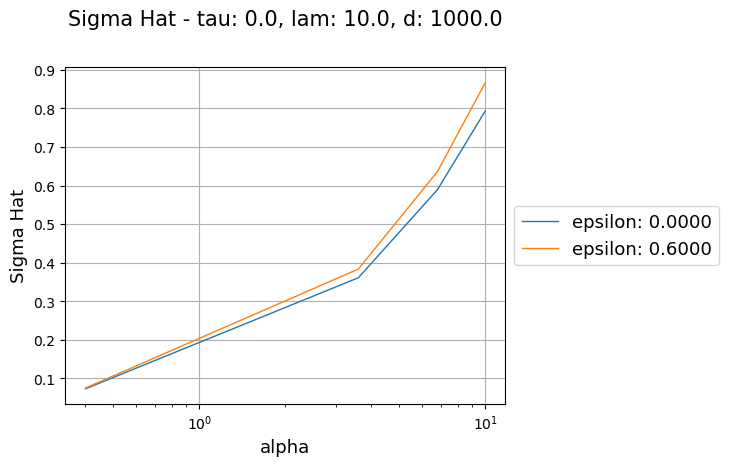

In [268]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

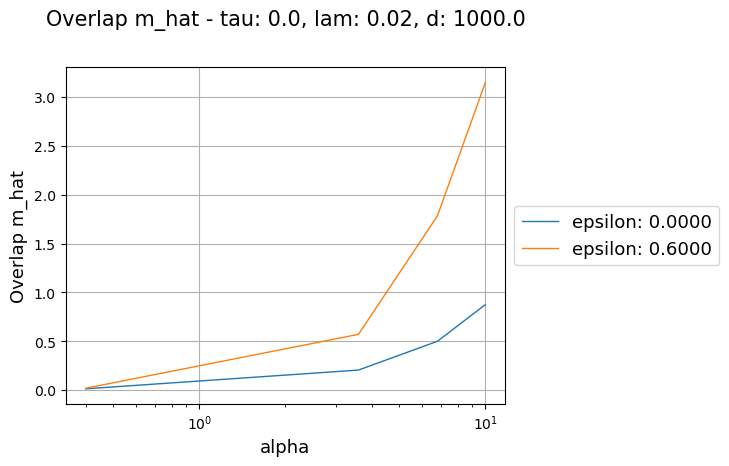

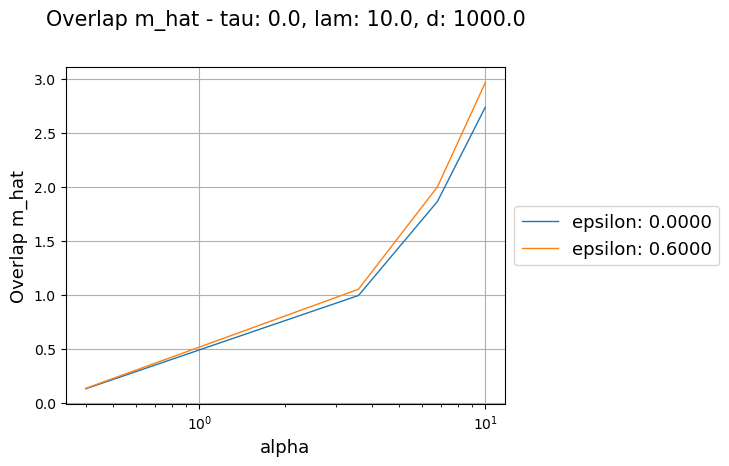

In [269]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

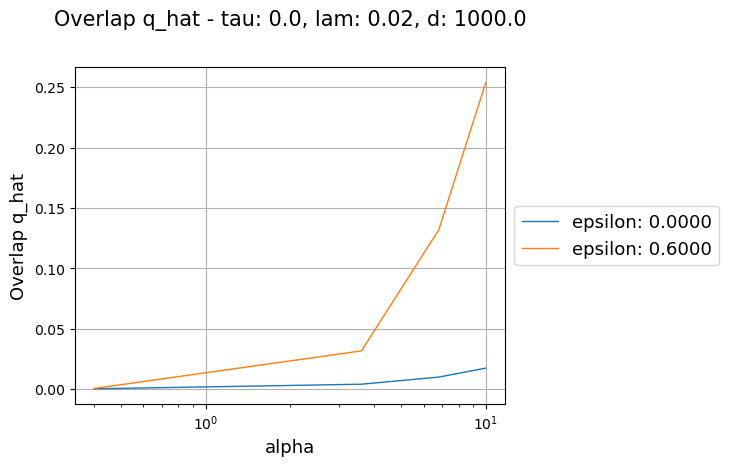

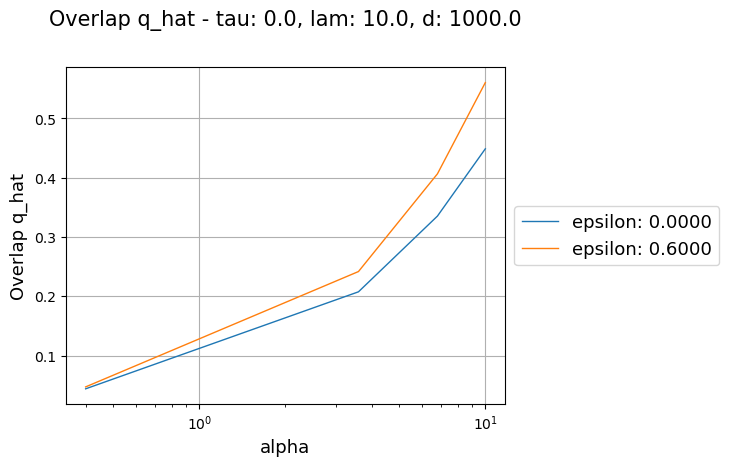

In [270]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None, log_y=False)

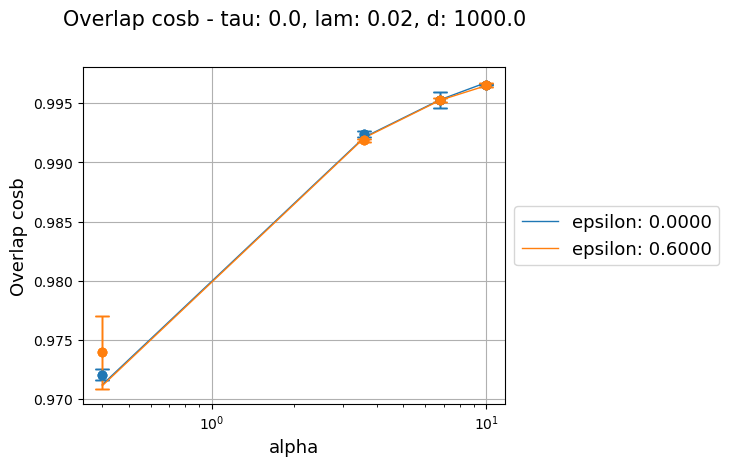

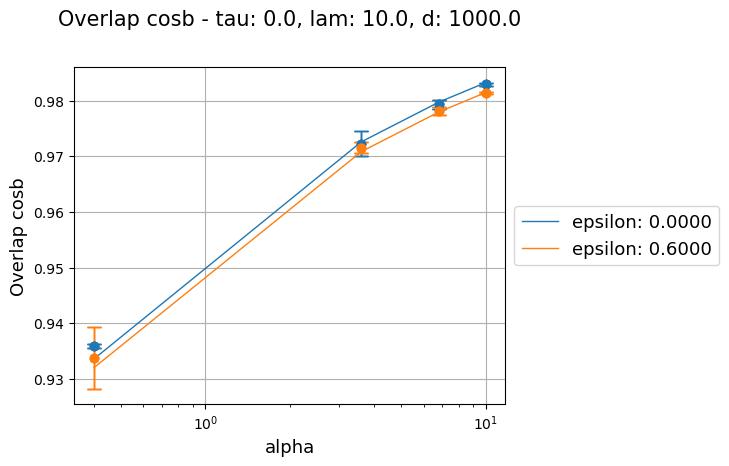

In [271]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

## Log-Log Plots of overlaps in State_evolution

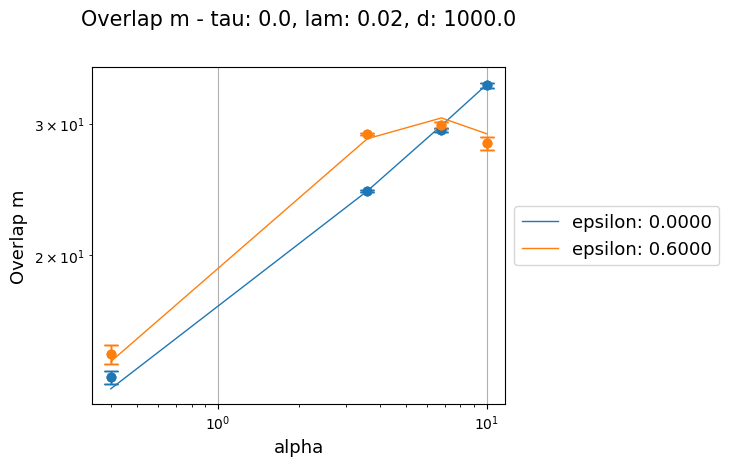

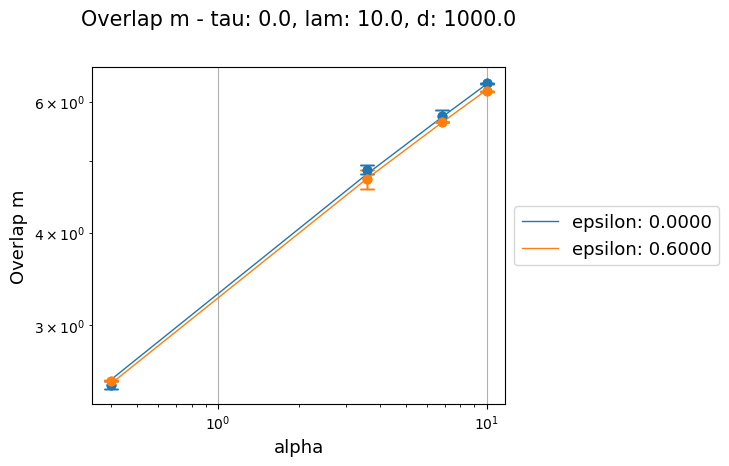

In [272]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

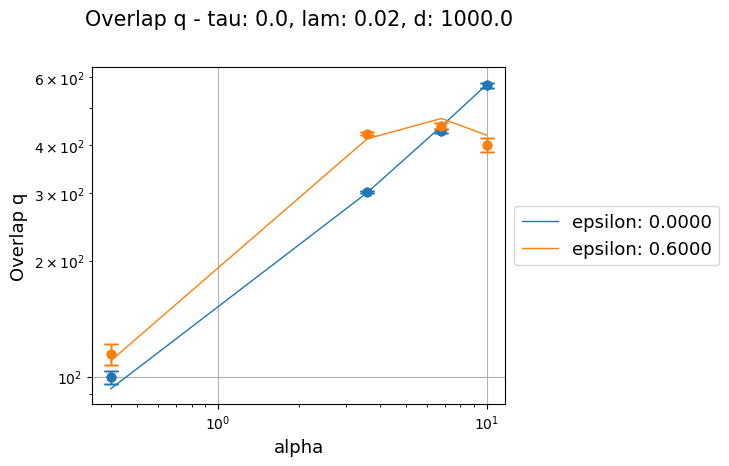

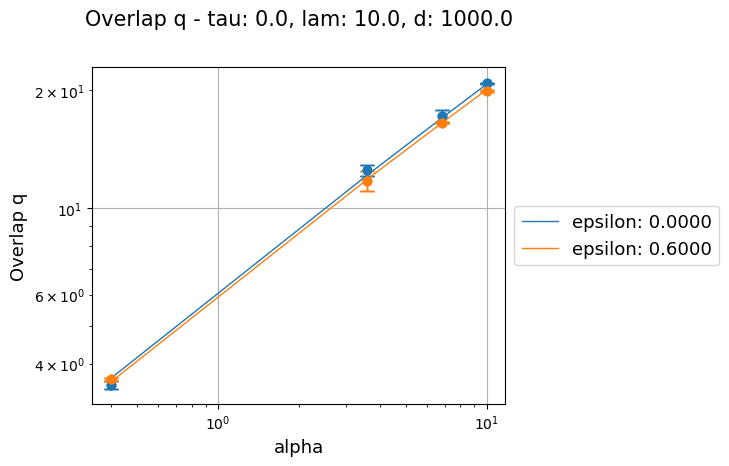

In [273]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

In [274]:
# create a log-log plot of the overlap sigma
# create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

In [275]:
# create a log-log plot of the overlap sigma_hat
# create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

In [276]:
# create a log-log plot of the overlap q_hat
# create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

In [277]:
# create a log-log plot of the overlap m_hat
# create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)